<a href="https://colab.research.google.com/github/Dhruvsandhu1/Computer-Vision-Transfer-Learning/blob/main/Transfer_Learning_With_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [2]:
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
!wget -nc https://archive.org/download/food-5-k/Food-5K.zip

--2025-06-27 11:24:08--  https://archive.org/download/food-5-k/Food-5K.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dn721600.ca.archive.org/0/items/food-5-k/Food-5K.zip [following]
--2025-06-27 11:24:09--  https://dn721600.ca.archive.org/0/items/food-5-k/Food-5K.zip
Resolving dn721600.ca.archive.org (dn721600.ca.archive.org)... 204.62.247.19
Connecting to dn721600.ca.archive.org (dn721600.ca.archive.org)|204.62.247.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  19.3MB/s    in 25s     

2025-06-27 11:24:36 (17.0 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [4]:
!unzip -qq -o Food-5K.zip

In [5]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [6]:
!ls Food-5K

evaluation  training  validation


In [7]:
!ls Food-5K/training

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

In [8]:
!mv Food-5K/* .

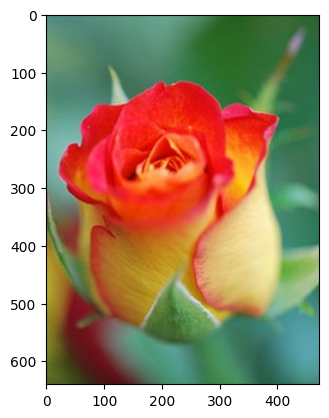

In [9]:
# look at an image for fun
plt.imshow(image.load_img('training/0_808.jpg'))
plt.show()

In [10]:
!mkdir data

In [11]:
!mkdir data/train
!mkdir data/test
!mkdir data/train/food
!mkdir data/train/nonfood
!mkdir data/test/food
!mkdir data/test/nonfood

In [12]:
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [13]:
train_path = 'data/train'
valid_path = 'data/test'

In [14]:
IMAGE_SIZE = [200, 200]

In [15]:
folders = glob(train_path + '/*')
folders

['data/train/food', 'data/train/nonfood']

In [61]:
K = len(folders)
K

2

In [17]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

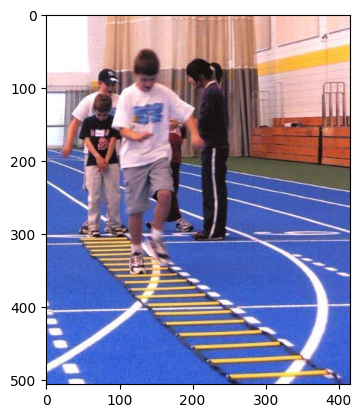

In [18]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [114]:
batch_size=128
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=IMAGE_SIZE,
    batch_size=batch_size
)
valid_ds=tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    image_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [27]:
class_names = train_ds.class_names
class_names

['food', 'nonfood']

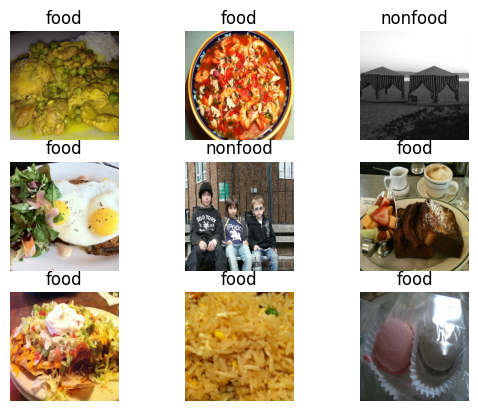

In [29]:
for images,labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [33]:
for images,labesl in train_ds.take(1):
  print(images.shape)
  print(labels.shape)

(128, 200, 200, 3)
(128,)


In [58]:
pretrained_model = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

In [59]:
pretrained_model.trainable = False

In [60]:
data_augmentation=tf.keras.Sequential(
    [
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1)
  ]
)

In [75]:
i=Input(shape=IMAGE_SIZE+[3])
x=preprocess_input(i)
x=data_augmentation(i)
x=pretrained_model(x)
x=Flatten()(x)
x=Dense(K,activation='softmax')(x)
model=Model(inputs=i,outputs=x,name="Custom_VGG")

In [77]:
model.summary()

Model: "Custom_VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │        36,866 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,751,554 (56.27 MB)

 Trainable params: 36,866 (144.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [79]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [80]:
batch_size = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  image_size=IMAGE_SIZE,
  batch_size=batch_size
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  valid_path,
  image_size=IMAGE_SIZE,
  batch_size=batch_size
)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [82]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [84]:
r = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=10,
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 625ms/step - accuracy: 0.7533 - loss: 4.4157 - val_accuracy: 0.9240 - val_loss: 1.7704
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 621ms/step - accuracy: 0.9194 - loss: 1.6738 - val_accuracy: 0.9550 - val_loss: 1.6601
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 0.9407 - loss: 0.8789 - val_accuracy: 0.9560 - val_loss: 1.6710
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step - accuracy: 0.9461 - loss: 0.9951 - val_accuracy: 0.9470 - val_loss: 1.6417
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 550ms/step - accuracy: 0.9586 - loss: 0.7065 - val_accuracy: 0.9540 - val_loss: 1.3657
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 554ms/step - accuracy: 0.9499 - loss: 0.7809 - val_accuracy: 0.9530 - val_loss: 1.5580
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 561ms/step - accuracy: 0.9602 - loss: 0.6931 - val_accuracy: 0.9590 - val_loss: 1.7443
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 566ms/step - accuracy: 0.9678 - loss: 0.4170 - val_accu

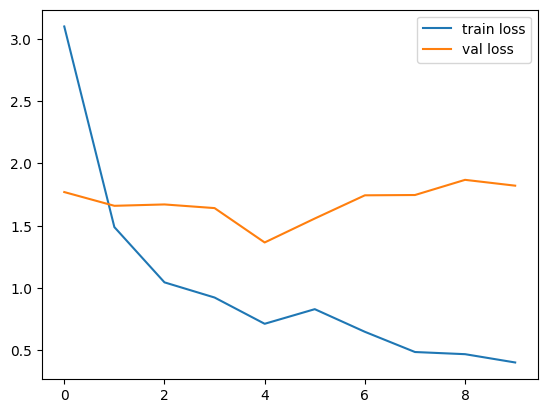

In [85]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

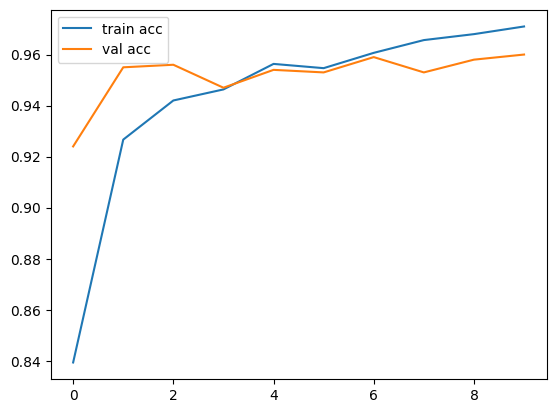

In [89]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [90]:
!ls evaluation

0_0.jpg    0_229.jpg  0_358.jpg  0_487.jpg  1_165.jpg  1_294.jpg  1_422.jpg
0_100.jpg  0_22.jpg   0_359.jpg  0_488.jpg  1_166.jpg  1_295.jpg  1_423.jpg
0_101.jpg  0_230.jpg  0_35.jpg	 0_489.jpg  1_167.jpg  1_296.jpg  1_424.jpg
0_102.jpg  0_231.jpg  0_360.jpg  0_48.jpg   1_168.jpg  1_297.jpg  1_425.jpg
0_103.jpg  0_232.jpg  0_361.jpg  0_490.jpg  1_169.jpg  1_298.jpg  1_426.jpg
0_104.jpg  0_233.jpg  0_362.jpg  0_491.jpg  1_16.jpg   1_299.jpg  1_427.jpg
0_105.jpg  0_234.jpg  0_363.jpg  0_492.jpg  1_170.jpg  1_29.jpg   1_428.jpg
0_106.jpg  0_235.jpg  0_364.jpg  0_493.jpg  1_171.jpg  1_2.jpg	  1_429.jpg
0_107.jpg  0_236.jpg  0_365.jpg  0_494.jpg  1_172.jpg  1_300.jpg  1_42.jpg
0_108.jpg  0_237.jpg  0_366.jpg  0_495.jpg  1_173.jpg  1_301.jpg  1_430.jpg
0_109.jpg  0_238.jpg  0_367.jpg  0_496.jpg  1_174.jpg  1_302.jpg  1_431.jpg
0_10.jpg   0_239.jpg  0_368.jpg  0_497.jpg  1_175.jpg  1_303.jpg  1_432.jpg
0_110.jpg  0_23.jpg   0_369.jpg  0_498.jpg  1_176.jpg  1_304.jpg  1_433.jpg
0_111.jpg  0_24

In [98]:
!ls

evaluation


In [ ]:
!mv evaluation/* .

In [93]:
!mkdir data/real_test
!mkdir data/real_test/food
!mkdir data/real_test/nonfood

In [105]:
!mv 0*.jpg data/real_test/nonfood
!mv 1*.jpg data/real_test/food

In [107]:
real_test='data/real_test'

In [108]:
IMAGE_SIZE = [200, 200]

In [112]:
real_test_files = glob(real_test + '/*/*.jpg')

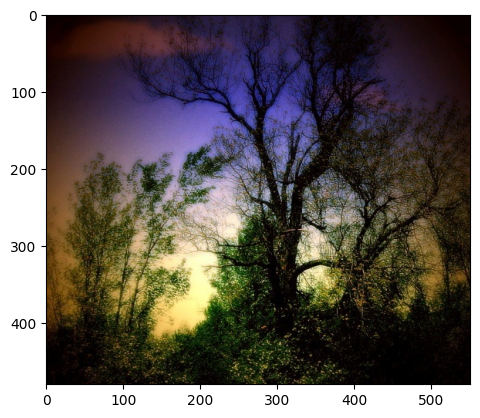

In [113]:
plt.imshow(image.load_img(np.random.choice(real_test_files)))
plt.show()

In [116]:
batch_size=128
real_test_ds=tf.keras.preprocessing.image_dataset_from_directory(
    real_test,
    image_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 1000 files belonging to 2 classes.


In [125]:
# Evaluate the model on the real test set
print("Evaluating model on real test set:")
loss,accuracy=model.evaluate(real_test_ds)
print(f"Loss:{loss}")
print(f"Accuracy:{accuracy}")


Evaluating model on real test set:
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.9564 - loss: 1.4799
Loss:1.8465685844421387
Accuracy:0.9539999961853027
